In [1]:
"""This module implements the Fréchet regression method from Petersen and Müller 2019.

The method is implemented in the context of estimation in the space of distribution
functions. Also, a simulation study is designed to compare with the methods outlined in
Petersen and Müller 2016.

"""

'This module implements the Fréchet regression method from Petersen and Müller 2019.\n\nThe method is implemented in the context of estimation in the space of distribution\nfunctions. Also, a simulation study is designed to compare with the methods outlined in\nPetersen and Müller 2016.\n\n'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import quadprog

from frechet_fda.function_class import Function
from frechet_fda.tools.function_tools import mean_func

In [37]:
N = 200
# predictor = np.random.uniform(-1, 1, (2, N)) # for case of multiple predictors
predictor = np.random.uniform(-1, 1, N)
predictor.sort()

In [38]:
def mu_from_x(x, mu0, beta, v1):
    """Sample mus from the first simulation setting in Petersen & Müller (2019)."""

    return np.random.normal(loc = mu0 + beta * x, scale = v1)

In [39]:
mus = mu_from_x(predictor, 0, 3, 0.25)

In [40]:
def sigma_from_x(x, sigma0, gamma, v2):
    """Sample sigmas from the first simulation setting Petersen & Müller (2019)."""
    sh = (sigma0 + gamma * x) ** 2 / v2
    sc = v2 / (sigma0 + gamma * x)

    return np.random.gamma(shape=sh, scale=sc)

In [41]:
sigmas = sigma_from_x(predictor, 3, 0.5, 2)

In [42]:
grid_size = 500
delta = 0
u = np.linspace(delta, 1 - delta, grid_size)

In [43]:
def gen_y_qf(mu, sigma, eval_points):
    """Generate quantile function of Y_i given X_i."""
    return mu[..., np.newaxis] + sigma[..., np.newaxis] * norm.ppf(eval_points)[np.newaxis, ...]

In [44]:
ys = gen_y_qf(mu = mus, sigma = sigmas, eval_points = u)

In [45]:
ys.shape

(200, 500)

In [46]:
qfs = [Function(u, y) for y in ys]

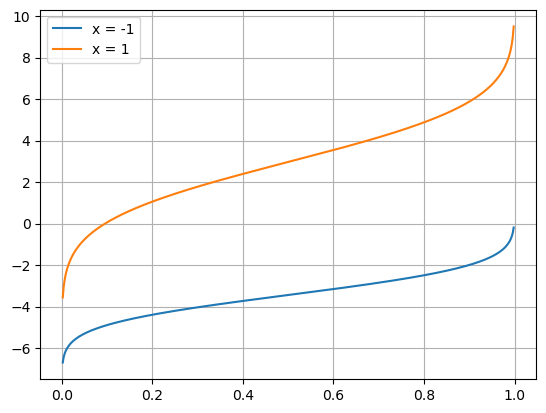

In [58]:
qfs[0].compare(qfs[199], label_self="x = -1", label_other="x = 1")

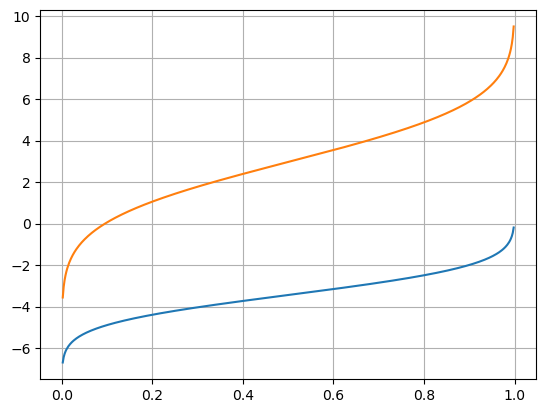

In [59]:
fig, ax = plt.subplots()
ax.plot(qfs[0].x, qfs[0].y)
ax.plot(qfs[199].x, qfs[199].y)
plt.grid()
plt.show()

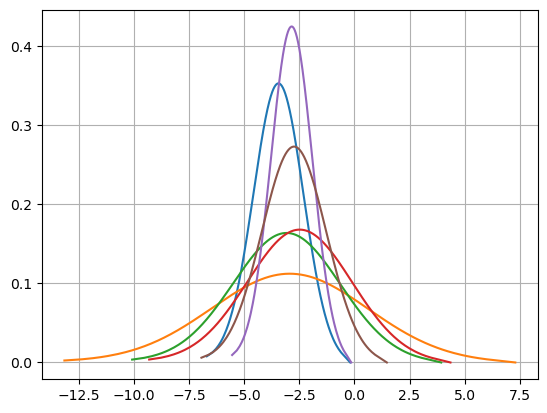

In [49]:
fig, ax = plt.subplots()
for qf in qfs[:6]:
    pdf = qf.invert().differentiate()
    ax.plot(
    pdf.x,
    pdf.y,
)
plt.grid()
plt.show()

In [63]:
def _empirical_weight_function(x_eval, predictor_values):
    predictor_values = np.atleast_2d(predictor_values)
    means = np.mean(predictor_values, axis = -1)
    cov_matrix = (
        predictor_values @ predictor_values.transpose()
        / predictor_values.shape[-1]
    )
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    s_in = 1 + (
        (predictor_values - means[..., np.newaxis]).transpose()
        @ inv_cov_matrix
        @ (x_eval - means)
    )
    return s_in

In [64]:
def qf_tilde(quantile_funcs, x, predictor_values):
    """Estimator for quantile function."""
    return mean_func(_empirical_weight_function(x, predictor_values) * quantile_funcs).y

In [65]:
x_grid = np.linspace(-1, 1, 20)

In [66]:
def solve_qp(x_grid, u):
    grid_size = len(u)
    qp_g = np.identity(grid_size)   # make sure P is symmetric
    qp_c = np.eye(grid_size, grid_size-1, k=-1) - np.eye(grid_size, grid_size-1)
    qp_b = np.zeros(grid_size-1)
    estimates = []
    for x in x_grid:
        qp_a = qf_tilde(qfs, x, predictor)
        constraints_check = qp_a[1:] - qp_a[:-1]
        # remove nans
        constraints_check = constraints_check[~np.isnan(constraints_check)]
        if np.all(constraints_check > 0):
            # If estimator valid qf, it is the optimal solution
            solution = qp_a
        else:
            # Else, find closest vector to estimator that is valid solution
            solution = quadprog.solve_qp(qp_g, qp_a, qp_c, qp_b)[0]
        estimates.append(Function(u, solution))
    return estimates

In [67]:
estimates = solve_qp(x_grid, u)

C:\Coding\frechet_fda\src\frechet_fda\function_class.py:169: RuntimeWarning: invalid value encountered in add
  comb_y = np.interp(comb_x, x, y) + np.interp(comb_x, val.x, val.y)


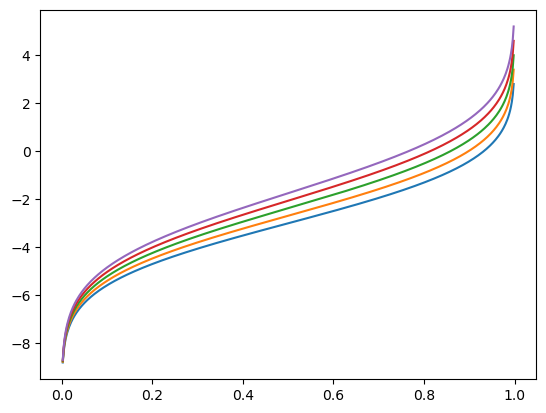

In [68]:
for func in estimates[:5]:
    plt.plot(func.x, func.y)

In [56]:
from mpl_toolkits.mplot3d import Axes3D

c:\Anaconda3\envs\frechet_fda\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:180: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


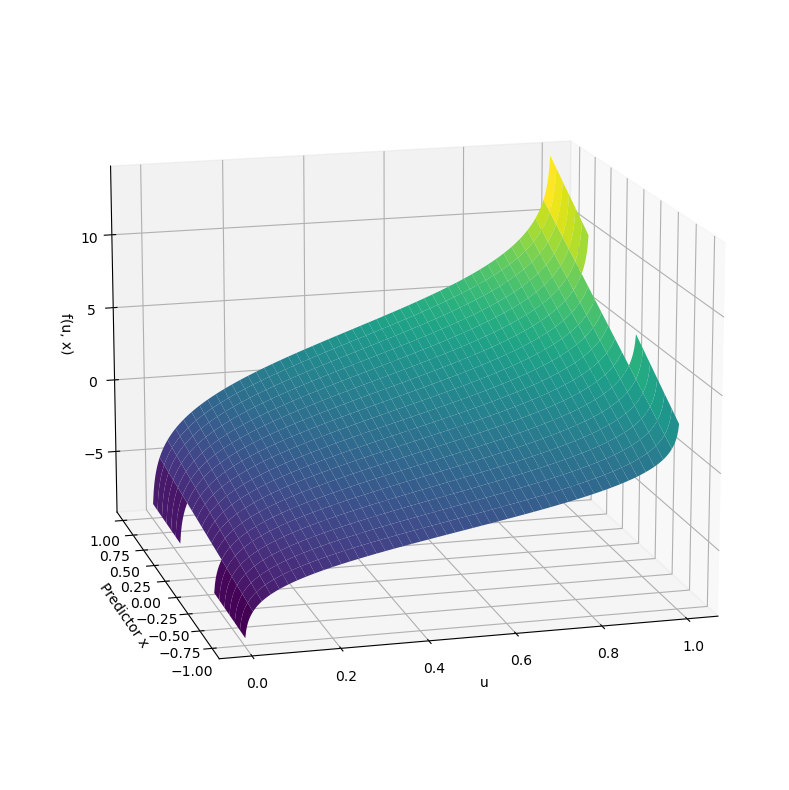

In [57]:
# Initialize a 2D array to hold f(u, x) values
z_values = np.zeros((len(x_grid), len(func.x)))

# Populate the array with estimates
for i, func in enumerate(estimates):
    z_values[i] = func.y

# Create the 3D surface plot
X, Y = np.meshgrid(func.x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z_values, cmap='viridis')

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=255)

ax.set_xlabel('u')
ax.set_ylabel('Predictor x')
ax.set_zlabel('f(u, x)', rotation = 0)
# ax.zaxis.set_rotate_label(False)  # disable automatic rotation
# ax.set_zlabel('label text', rotation=0)
plt.tight_layout()
plt.show()